<h1><span style='color:#164cf0'>|</span> Intro</h1>
<font size="5">
When It comes to CNN one of the most famous architecture is <strong>LeNet-5</strong> created by Yann Lecun back in 1998, this type of CNN is particulary efficient (despite it's simplicity) and has been using a lot for handwritten digit recognition tasks.
</font> 

the <mark>structure</mark> of the Net is the following:

  
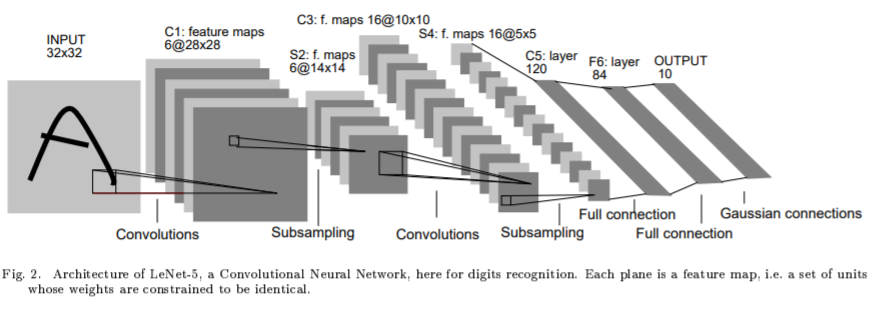  
   
<font size="5">
as we can see it is composed by 5 layers wich 3 of them are Convolution layers alternated with average pooling layers

the net ends with 2 dense layers with respectively 84 and 10 neurons 
</font>

<h2><span style='color:#164cf0'>|</span> Import the libraries</h2>

In [ ]:
import pandas as pd
import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np
import statistics

#plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

<h2><span style='color:#164cf0'>|</span> Load the data and prepare them</h2>

In [ ]:
#import the data
test_set = pd.read_csv("../input/digit-recognizer/test.csv")
train_set = pd.read_csv("../input/digit-recognizer/train.csv")

#prepare the data
y_train_label = train_set['label']
x_train = train_set.drop(['label'], axis = 1)

x_train = x_train/255.0
x_test = test_set/255.0

#reshepe
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

#convert labels to category
y_train = keras.utils.np_utils.to_categorical(y_train_label, 10)

<font size="4"><strong>Check out if the number of samples are weel distributed among all the classes</strong></font>

In [ ]:
y_train_label.value_counts()

In [ ]:
y_train_label.value_counts()
plt.figure(figsize=(25,8))
sns.countplot(x="label",data=train_set)
plt.axhline(statistics.mean(y_train_label.value_counts().values),color='black')

<font size='5'>as we can see the number of samples is almost the same for every class, so we don't need to do a stritified division of the DF</font>

In [ ]:
#create a validation test 38.000 : 42:000
x_val = x_train[38000:]
y_val = y_train[38000:]

x_train = x_train[:38000]
y_train = y_train[:38000]

<h2><span style='color:#164cf0'>|</span> Plot data samples</h2>

In [ ]:
#show data
randoms = np.random.randint(0,len(y_train),size = 25)
fig, axs = plt.subplots(5,5,figsize = (20,20))

for i, ax in zip(randoms, axs.ravel()):
    ax.imshow(x_train[i].reshape(28,28), cmap=plt.cm.binary)
    ax.set_title(f"label: {np.argmax(y_train[i])}")
    ax.axis('off')

-----------

# Vanilla model
<font size="5">let's start by implementing the vanilla version of the model</font>

<h2>1.1 <span style='color:#164cf0'>|</span> Create the vanilla version of the model</h2>

In [ ]:
# CNN
model = keras.models.Sequential()

model.add(layers.Conv2D(6,kernel_size = (5,5), input_shape = (28,28,1), activation = 'tanh', padding = 'same'))
model.add(layers.AveragePooling2D(pool_size = (2,2),strides = (2,2)))

model.add(layers.Conv2D(16,kernel_size = (5,5), activation = 'tanh'))
model.add(layers.AveragePooling2D(pool_size = (2,2), strides = (2,2)))

model.add(layers.Conv2D(120, kernel_size = (5,5), activation = 'tanh'))

model.add(layers.Flatten())
model.add(layers.Dense(84, activation = 'tanh'))
model.add(layers.Dense(10, activation = 'softmax'))
    
model.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

<h2>1.2 <span style='color:#164cf0'>|</span> Fit the model</h2>

In [ ]:
hist = model.fit(x = x_train, y = y_train, epochs = 50, batch_size = 128, validation_data = (x_val,y_val), verbose = 1)

<h2>1.3 <span style='color:#164cf0'>|</span> Evaluate the accuracy</h2>

In [ ]:
plt.figure(figsize=(25,8))

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.legend(['train', 'validation'])

<h2>1.4 <span style='color:#164cf0'>|</span> Predictions on test data</h2>

In [ ]:
#test data
test_pred = model.predict(x_test)
test_pred = [np.argmax(x) for x in test_pred]

#create the prediction DF
test_pred_df = pd.DataFrame(data = {
    'ImageId': list(range(1,len(test_pred)+1)),
    'Label'  :test_pred
})

#save predictions as csv
test_pred_df.to_csv('./test_preds.csv', index = False, sep=',')

<h2>1.5 <span style='color:#164cf0'>|</span> results</h2>
<font size="5">submitting the predictions we obtain a <mark>0.97671</mark> precision, let's see how a more elaborated version of  the model perform</font>

---------------

# Upgraded version of the model + Data augmentation

<font size="5">For this upgraded version of the model i will insert batch normalization layers and replace the average pooling layers with Max pooling layers</font>

<h2>2.1 <span style='color:#164cf0'>|</span> Create the model</h2>

In [ ]:
model_2 = keras.models.Sequential()

model_2.add(layers.Conv2D(6,kernel_size = (5,5), input_shape = (28,28,1), activation = 'tanh', padding = 'same'))
model_2.add(layers.MaxPool2D(pool_size = (2,2),strides = (2,2)))
model_2.add(layers.BatchNormalization())

model_2.add(layers.Conv2D(16,kernel_size = (6,6), activation = 'tanh', padding = 'same'))
model_2.add(layers.MaxPool2D(pool_size = (3,3), strides = (3,3)))
model_2.add(layers.BatchNormalization())

model_2.add(layers.Conv2D(120, kernel_size = (8,8), activation = 'tanh', padding = 'same'))

model_2.add(layers.Flatten())
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.4))
model_2.add(layers.Dense(84, activation = 'tanh'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.4))
model_2.add(layers.Dense(10, activation = 'softmax'))
    
model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

<h2>2.2 <span style='color:#164cf0'>|</span> Data augmentation</h2>

In [ ]:
imageDataGen = ImageDataGenerator(width_shift_range=0.1,  # randomly shift images horizontally
                                  height_shift_range=0.1, # randomly shift images vertically
                                  rotation_range=10,      # randomly rotate images in the range provided.
                                  zoom_range=0.1)         # Randomly zoom image 

imageDataGen.fit(x_train)

<h2>2.3 <span style='color:#164cf0'>|</span> Fit the model</h2>

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = './model_2_best.hdf5',monitor = 'val_accuracy',save_best_only = True,save_freq = 'epoch')
]
history_2 = model_2.fit(x = imageDataGen.flow(x_train, y_train, batch_size = 64), epochs = 50, validation_data = (x_val, y_val), verbose = 1,callbacks=callbacks)

In [ ]:
plt.figure(figsize=(25,8))

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

plt.legend(['train', 'validation'])

<h2>2.4 <span style='color:#164cf0'>|</span> predictions on test set</h2>

In [ ]:
#predictions for the text set
model_best = keras.models.load_model('./model_2_best.hdf5')
test_preds_2 = model_best.predict(x_test)
test_preds_2 = [np.argmax(x) for x in test_preds_2]

#create a dictionary for the test predictions
test_pred_df_2 = pd.DataFrame(data={
    'ImageId' : list(range(1,len(test_preds_2)+1)),
    'Label'   : test_preds_2
})

#save the predictions as csv
test_pred_df_2.to_csv('./best_2.0_preds_2.csv', index = False, sep = ',')

<h2>2.5 <span style='color:#164cf0'>|</span> results</h2>
<font size="5">the upgraded version of the model got a score of <mark>0.9910</mark>

-------------

# Create an Ensemble learning model

<font size="5">The aim of this sectionis to train 5 euqually structured models and then from those models create an ensemble learning model</font>

<h2>3.1 <span style='color:#164cf0'>|</span> train the models</h2>

In [ ]:
histories = [0]*5

for model in range(5):
    
    keras.backend.clear_session()
    print('---------------- training model No:{} ----------------'.format(model))
    callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = './model_2_fit_{}.hdf5'.format(model),monitor = 'val_accuracy',save_best_only = True,save_freq = 'epoch')
]
    histories[model] = model_2.fit(x = imageDataGen.flow(x_train, y_train, batch_size = 64), epochs = 30, validation_data = (x_val, y_val), verbose = 1,callbacks=callbacks)    

In [ ]:
models = [0]*5
for x in range(len(models)):
    models[x] = keras.models.load_model('./model_2_fit_{}.hdf5'.format(x))

In [ ]:
fig, axs = plt.subplots(5,2)
fig.set_figheight(40)
fig.set_figwidth(25)

i = 0
for ax, history in zip(axs,histories):
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('accuracy model {}'.format(i))
    plt.legend(['train accuracy', 'validation accuracy'])
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('loss model {}'.format(i))
    plt.legend(['train loss', 'validation loss'])
    i+=1

<h2>3.2 <span style='color:#164cf0'>|</span> predictions on the test set</h2>

In [ ]:
predictions = [0]*5
for index, model in enumerate(models):
    predictions[index] = model.predict(x_test)

<h2>3.3 <span style='color:#164cf0'>|</span> merge predictions thought average</h2>
<font size ="5">join all the predictions doing the average between them</font>

In [ ]:
ensamble_pred = []

for ind in range(len(predictions[0])):
    ensamble_pred.append((predictions[0][ind] + predictions[1][ind] + predictions[2][ind] + predictions[3][ind] + predictions[4][ind])/5)

ensamble_prediction = [np.argmax(x) for x in ensamble_pred]

#create a dictionary for the test predictions
test_pred_ensamble = pd.DataFrame(data={
    'ImageId' : list(range(1,len(ensamble_prediction)+1)),
    'Label'   : ensamble_prediction
})

#save the predictions as csv
test_pred_ensamble.to_csv('./best_2_ensamble.csv', index = False, sep = ',')

<h2>3.4 <span style='color:#164cf0'>|</span> results</h2>
<font size="5">thanks to the ensemble model we reach a precision of <mark>0.99325</mark>